In [1]:
# ───────────────────── 1. LIBRERÍAS ─────────────────────────────
import matplotlib.animation as animation, matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from matplotlib.ticker import FuncFormatter
from utils import *

In [2]:
# 1. DATA ---------------------------------------------------------
df = pd.read_csv("../data/Fig3_AllPeru_RegionDateMovements.txt", sep="\t")
for col in ("ChildDate", "ParentDate"):
    df[col] = df[col].apply(decimal_to_datetime)

for col in ("ChildRegion", "ParentRegion"):
    df[col] = df[col].apply(norm_dep)

df = df[df["ParentDate"].between("2020-03-01", "2020-12-31")]  # rango de prueba
fechas = pd.to_datetime(df["ParentDate"]).sort_values().unique()

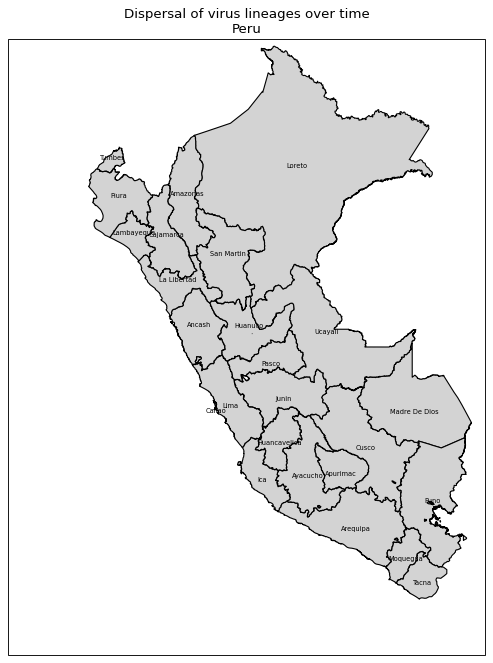

In [4]:
# 2. MAPA BASE ----------------------------------------------------
gdf, coords = prepare_coords("../data/DEPARTAMENTOS_inei_geogpsperu_suyopomalia/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp")
coords = {norm_dep(dep): xy for dep, xy in coords.items()}
fig, ax = make_base_map(gdf, coords, figsize=(8, 10), dpi=80)

In [5]:
# 3. ARTISTAS Y BEZIERS ------------------------------------------
puntos, lineas, flechas, date_text = build_artists(ax)
beziers = precompute_beziers(df, coords, n=70,  amp=1.75)
# convierte los dos extremos del array 'fechas' a número de días
vmin = mdates.date2num(fechas[0])
vmax = mdates.date2num(fechas[-1])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

In [7]:
# ─────────────────────────────
#  BARRA DE COLOR
# ─────────────────────────────
# 1) eje para la barra (posición relativa a la figura)
cax = fig.add_axes([0.20,   # left   (0 → izq / 1 → der)
                    0.05,   # bottom (0 → abajo)
                    0.60,   # width  (60 % del ancho)
                    0.03])  # height (alto de la barra)

# 2) barra propiamente dicha
cb = ColorbarBase(cax, cmap=sm.cmap, norm=sm.norm,
                  orientation="horizontal")
cb.ax.xaxis.set_label_position('top')   # mueve la posición
# --- 1.  Colocamos una marca por mes -----------
cb.ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# --- 2. Averigua la 1.ª marca real (float) -----------------------
first_tick = cb.ax.get_xticks()[0]          # primer valor numérico
first_dt   = mdates.num2date(first_tick)    # datetime correspondiente

# --- 3. Formateador: mes siempre; año solo en la 1.ª -------------
def month_with_one_year(x, pos, first=first_dt):
    dt = mdates.num2date(x)
    if dt.month == first.month and dt.year == first.year:
        return f"{dt:%b}\n{dt:%Y}"          # “Mar\n2020”, por ejemplo
    else:
        return f"{dt:%b}"                   # “Abr”, “May”, …

cb.ax.xaxis.set_major_formatter(FuncFormatter(month_with_one_year))

# 4) texto descriptivo
cb.set_label("Date", size=9, labelpad=1)
# cb.ax.tick_params(labelsize=5, pad=3)
# --- 3.  Opcional: separa un poco las marcas --------------
cb.ax.tick_params(labelsize=8, pad=2)

# opcional: línea de borde tenue
for spine in cb.ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)
    spine.set_color("#666")

In [ ]:
# 4. ANIMACIÓN ----------------------------------------------------
ani = animation.FuncAnimation(
        fig,
        update_animation,
        frames=len(fechas),
        init_func=lambda: init_animation(puntos, lineas, flechas, date_text),
        fargs=(fechas, df, puntos, lineas, flechas, beziers, coords, sm, ax, date_text),  # ← pasa date_text
        blit=False,
        interval=500)

ani.save("../output/preview_mar_abr_2020.mp4",
         writer="ffmpeg", fps=6, dpi=80,
         extra_args=["-preset", "veryfast", "-crf", "24"])